# Comparing Classification Models

We want to compare various classification models for the customer dataset. We'll look at logistic regression, LDA, QDA, and $k$-nearest neighbors.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We'll look at logistic regression, LDA, QDA, and KNN
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# We'll standardize and split data into training/testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Need to measure "goodness"
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, average_precision_score, precision_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

In [2]:
# Read in the data and print out its shape
cust = pd.read_csv('./data/customers_clean.csv')
print(cust.shape)

(12266, 11)


In [3]:
# Let's drop the following columns:
# cust_id, join_date, last_purchase_date
new_cust = cust.drop(columns=['cust_id','join_date','last_purchase_date'])
new_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            12266 non-null  object
 1   age               12266 non-null  int64 
 2   marital_status    12266 non-null  object
 3   household_income  12266 non-null  int64 
 4   home_ownership    12266 non-null  object
 5   num_children      12266 non-null  int64 
 6   num_vehicles      12266 non-null  int64 
 7   spend             12266 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 766.8+ KB


In [4]:
# Create dummies and save in new DataFrame
data = pd.get_dummies(new_cust, dtype=int, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
dtypes: int64(9)
memory usage: 862.6 KB


## Create "big spender"

We want to convert the $y$ variable, `spend`, into a binary variable where 1 represents a big spender and a 0 otherwise. We can set the cutoff anywhere we want. Looking at the summary statistics from above, let's use \$4,700 (what you told me to do) as the cutoff. We can use the function `pd.cut()`.

In [5]:
data['big_spender'] = pd.cut(data.spend, bins=[0,4700,10000], right=True, labels=[0,1]).astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12266 entries, 0 to 12265
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   age                       12266 non-null  int64
 1   household_income          12266 non-null  int64
 2   num_children              12266 non-null  int64
 3   num_vehicles              12266 non-null  int64
 4   spend                     12266 non-null  int64
 5   gender_M                  12266 non-null  int64
 6   marital_status_unmarried  12266 non-null  int64
 7   home_ownership_rent       12266 non-null  int64
 8   home_ownership_unknown    12266 non-null  int64
 9   big_spender               12266 non-null  int64
dtypes: int64(10)
memory usage: 958.4 KB


In [6]:
# See summary statistics
data.describe()

,age,household_income,num_children,num_vehicles,spend,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown,big_spender
count,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000,12266.000000
mean,37.864096,301670.381135,2.505544,2.503913,4531.936736,0.315669,0.251834,0.252323,0.101582,0.515245
std,10.663234,115752.377718,1.707281,1.697419,1597.594658,0.464801,0.434084,0.434364,0.302110,0.499788
min,20.000000,65003.000000,0.000000,0.000000,1468.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,217028.250000,1.000000,1.000000,3237.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,307364.500000,3.000000,3.000000,4766.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,47.000000,399456.250000,4.000000,4.000000,5723.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,56.000000,489982.000000,5.000000,5.000000,7500.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split Data into Training and Test Sets

Need to first define `X` and `y`. Then we can try train/test split.

In [7]:
# define the output variable, y
y = data.big_spender

# define the X
# Notice this time we are only dropping the original 'spend'
# and the 'big_spender' columns.
X = data.drop(columns=['spend', 'big_spender'])

In [8]:
# Time to split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=163)

In [9]:
# What is the percentage of big spenders in both training and test?
print(f'Training percentage of big spenders is {y_train.mean():.2%}')
print(f'Testing percentage of big spenders is  {y_test.mean():.2%}')

Training percentage of big spenders is 50.87%
Testing percentage of big spenders is  54.16%


## Scale the Data

Fit only on the training set. Use that fit to transform both the training and test sets.

In [10]:
# Fit the scaler on just the training X variables
# Let's start with StandardScaler which will center
# each variable at 0 and give each a unit variance (=1)
s_scaler = StandardScaler().fit(X_train)
s_scaler

StandardScaler()

In [11]:
# Transform X_train and put in DataFrame
X_train_ss = pd.DataFrame(s_scaler.transform(X_train), columns=X_train.columns)

# Take a look at the DataFrame
X_train_ss.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03,9.812000e+03
mean,4.924267e-17,-1.578662e-16,-6.626035e-17,-9.486455e-17,-4.127694e-17,6.752763e-17,-5.630320e-17,-1.375898e-17
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-1.668967e+00,-2.053426e+00,-1.469745e+00,-1.479061e+00,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
25%,-8.273933e-01,-7.266243e-01,-8.831620e-01,-8.884476e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
50%,1.418062e-02,4.409943e-02,2.900033e-01,2.927784e-01,-6.788013e-01,-5.795470e-01,-5.842546e-01,-3.310260e-01
75%,8.557545e-01,8.439403e-01,8.765859e-01,8.833914e-01,1.473185e+00,1.725486e+00,1.711583e+00,-3.310260e-01
max,1.697328e+00,1.642012e+00,1.463169e+00,1.474004e+00,1.473185e+00,1.725486e+00,1.711583e+00,3.020911e+00


In [12]:
# Transform X_test and put in DataFrame
X_test_ss = pd.DataFrame(s_scaler.transform(X_test), columns=X_test.columns)
X_test_ss.describe()

,age,household_income,num_children,num_vehicles,gender_M,marital_status_unmarried,home_ownership_rent,home_ownership_unknown
count,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000
mean,0.007360,0.022660,-0.000181,-0.001084,0.002573,0.004695,-0.024796,0.047330
std,0.985393,1.032056,1.007286,1.012526,1.001222,1.002880,0.985813,1.060911
min,-1.668967,-2.051661,-1.469745,-1.479061,-0.678801,-0.579547,-0.584255,-0.331026
25%,-0.827393,-0.746133,-0.883162,-0.888448,-0.678801,-0.579547,-0.584255,-0.331026
50%,0.014181,0.098260,0.290003,-0.002528,-0.678801,-0.579547,-0.584255,-0.331026
75%,0.855755,0.898707,0.876586,0.883391,1.473185,1.725486,-0.584255,-0.331026
max,1.697328,1.641855,1.463169,1.474004,1.473185,1.725486,1.711583,3.020911


# Function to Look at Different Models

I have write a custom function that will take in different models (classifiers) and compute the different metrics so we can compare the different classifiers easily.

In [13]:
# define our function
def modelMetrics(classifier, name, X_test, y_test):
    """
    We want to see how the different models react to the same 
    dataset. We should capture multiple metrics for each model.
    
    classifier: the classifier we are capturing metrics for
    
    name: give it a descriptive name
    
    X_test: the X array for the test set
    
    y_test: the output variable (actual) for test set
    """
    retVal = {}
    
    metrics = {}
    predictions = classifier.predict(X_test)
    metrics['a_score'] = accuracy_score(y_test, predictions)
    metrics['r_score'] = recall_score(y_test, predictions)
    metrics['p_score'] = precision_score(y_test, predictions)
    metrics['f1_score'] = f1_score(y_test, predictions)
    metrics['f2_score'] = fbeta_score(y_test, predictions, beta=2)
    metrics['f0.5_score'] = fbeta_score(y_test, predictions, beta=0.5)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    totPositives = y_test.sum()
    totNegatives = len(y_test) - totPositives
    
    # Error rate negatives = false positives / total negatives
    metrics['errorNegatives'] = fp/totNegatives
    # Accuracy for negatives = true negatives / total negatives
    metrics['accNegatives'] = tn/totNegatives
    # Error rate for positives = false negatives / total positives
    metrics['errorPositives'] = fn/totPositives
    # Accuracy for positives = true positives / total positives
    metrics['accPositives'] = tp/totPositives

    metrics['roc_auc_score'] = roc_auc_score(y_test,
                                             classifier.predict_proba(X_test)[:,1])
    metrics['avg_p_score'] = average_precision_score(y_test,
                                                     classifier.predict_proba(X_test)[:,1])
    
    retVal[name] = metrics
    
    return pd.DataFrame(retVal)

# Create a Logistic Model

We will use the scaled data and include all the features.

In [14]:
# Create a LogisticRegression
logReg = LogisticRegression()

# fit the logistic regression model
logReg.fit(X_train_ss, y_train)

LogisticRegression()

In [15]:
# Print out the estimated intercept and coefficients
print(logReg.intercept_)
print(logReg.coef_)

[0.02811998]
[[ 0.01462065  1.22631463  0.03141938 -0.04495375  0.05562195  0.01223148
   0.09491624  0.04587892]]


In [16]:
# Get the model metrics using user-defined function
lr_metrics = modelMetrics(logReg, 'logistic regression', X_test_ss, y_test)
lr_metrics

,logistic regression
a_score,0.715159
accNegatives,0.697778
accPositives,0.729872
avg_p_score,0.841033
errorNegatives,0.302222
...,...
f1_score,0.735127
f2_score,0.731965
p_score,0.740458
r_score,0.729872


In [17]:
print(lr_metrics)

                logistic regression
a_score                    0.715159
accNegatives               0.697778
accPositives               0.729872
avg_p_score                0.841033
errorNegatives             0.302222
errorPositives             0.270128
f0.5_score                 0.738316
f1_score                   0.735127
f2_score                   0.731965
p_score                    0.740458
r_score                    0.729872
roc_auc_score              0.790408


In [21]:
print(lr_metrics.to_string())

                logistic regression
a_score                    0.715159
accNegatives               0.697778
accPositives               0.729872
avg_p_score                0.841033
errorNegatives             0.302222
errorPositives             0.270128
f0.5_score                 0.738316
f1_score                   0.735127
f2_score                   0.731965
p_score                    0.740458
r_score                    0.729872
roc_auc_score              0.790408


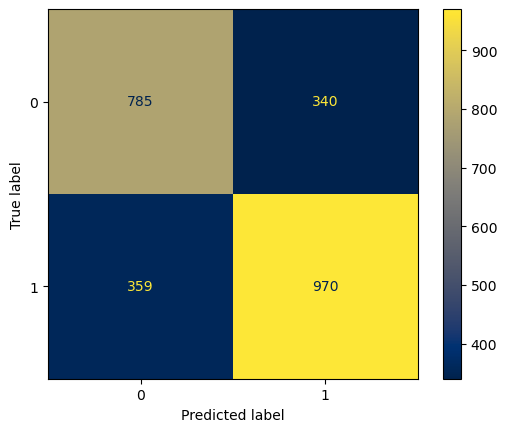

In [22]:
# Let's make a plot of confusion matrix
ConfusionMatrixDisplay.from_estimator(logReg, X_test_ss, y_test, cmap='cividis')

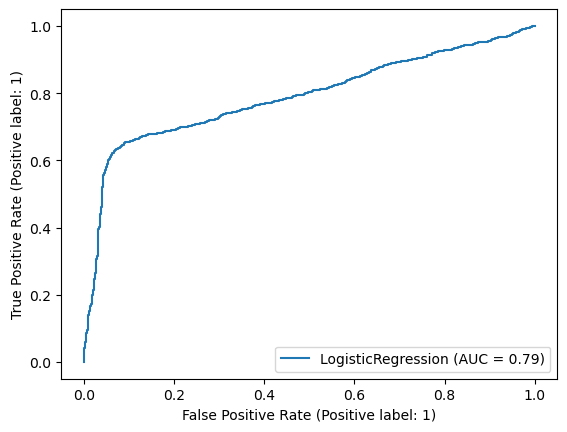

In [23]:
# Create an ROC Curve display
RocCurveDisplay.from_estimator(logReg, X_test_ss, y_test)

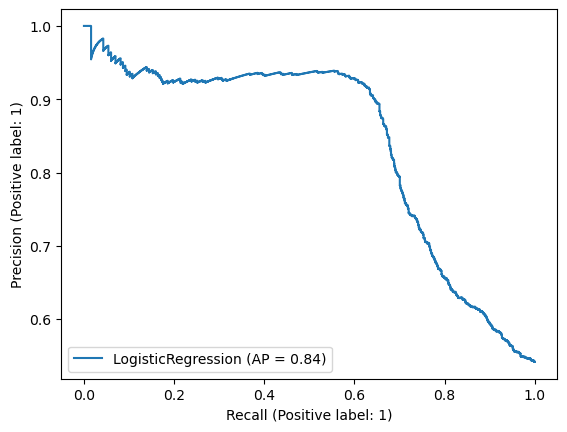

In [24]:
# Make a Precision Recall display
PrecisionRecallDisplay.from_estimator(logReg, X_test_ss, y_test)

# Linear Discriminant Analysis
Let's now try LDA. We already imported the appropriate packages for LDA.

In [25]:
# Create an LDA instance
lda = LinearDiscriminantAnalysis()

In [26]:
# Fit the LDA model with X and y training set created previously
lda.fit(X_train_ss, y_train)

LinearDiscriminantAnalysis()

In [27]:
# Get the model metrics using user-defined function
lda_metrics = modelMetrics(lda, 'LDA', X_test_ss, y_test)
lda_metrics

,LDA
a_score,0.715159
accNegatives,0.695111
accPositives,0.732129
avg_p_score,0.841129
errorNegatives,0.304889
...,...
f1_score,0.735728
f2_score,0.733565
p_score,0.739362
r_score,0.732129


# Quadratic Discriminant Analysis
We can also try QDA (already imported package)

In [28]:
# Create a QDA instance
qda = QuadraticDiscriminantAnalysis()

In [29]:
# Fit the qda with X and y
qda.fit(X_train_ss, y_train)

QuadraticDiscriminantAnalysis()

In [30]:
# Get the model metrics using user-defined function
qda_metrics = modelMetrics(qda, 'QDA', X_test_ss, y_test)
qda_metrics

,QDA
a_score,0.721271
accNegatives,0.719111
accPositives,0.723100
avg_p_score,0.840339
errorNegatives,0.280889
...,...
f1_score,0.737529
f2_score,0.728803
p_score,0.752545
r_score,0.723100


# KNN
Might as well try $k$-nearest neighbors. You pick $k$, so it will be your fault not mine.

In [31]:
# Let's use k=??
knn = KNeighborsClassifier(n_neighbors=7)

In [32]:
# fit the model
knn.fit(X_train_ss, y_train)

KNeighborsClassifier(n_neighbors=7)

In [34]:
# Get the model metrics using user-defined function
knn7_metrics = modelMetrics(knn, 'KNN-7', X_test_ss, y_test)
knn7_metrics

,KNN-7
a_score,0.726161
accNegatives,0.784000
accPositives,0.677201
avg_p_score,0.800607
errorNegatives,0.216000
...,...
f1_score,0.728155
f2_score,0.696702
p_score,0.787402
r_score,0.677201


In [36]:
# Let's try another value for k ... k=??
knn20 = KNeighborsClassifier(n_neighbors=20)
knn20.fit(X_train_ss, y_train)

KNeighborsClassifier(n_neighbors=20)

In [37]:
# Get the model metrics using user-defined function
knn20_metrics = modelMetrics(knn20, 'KNN-20', X_test_ss, y_test)
knn20_metrics

,KNN-20
a_score,0.755094
accNegatives,0.872889
accPositives,0.655380
avg_p_score,0.822755
errorNegatives,0.127111
...,...
f1_score,0.743491
f2_score,0.687994
p_score,0.858974
r_score,0.655380


In [38]:
# Put all metrics in one DataFrame to examine
all_dfs = [lr_metrics, lda_metrics, qda_metrics, knn7_metrics, knn20_metrics]

In [39]:
# Look at all metrics together
all_metrics = pd.concat(all_dfs, axis=1)
all_metrics

,logistic regression,LDA,QDA,KNN-7,KNN-20
a_score,0.715159,0.715159,0.721271,0.726161,0.755094
accNegatives,0.697778,0.695111,0.719111,0.784000,0.872889
accPositives,0.729872,0.732129,0.723100,0.677201,0.655380
avg_p_score,0.841033,0.841129,0.840339,0.800607,0.822755
errorNegatives,0.302222,0.304889,0.280889,0.216000,0.127111
...,...,...,...,...,...
f1_score,0.735127,0.735728,0.737529,0.728155,0.743491
f2_score,0.731965,0.733565,0.728803,0.696702,0.687994
p_score,0.740458,0.739362,0.752545,0.787402,0.858974
r_score,0.729872,0.732129,0.723100,0.677201,0.655380


In [41]:
print(all_metrics)

                logistic regression       LDA       QDA     KNN-7    KNN-20
a_score                    0.715159  0.715159  0.721271  0.726161  0.755094
accNegatives               0.697778  0.695111  0.719111  0.784000  0.872889
accPositives               0.729872  0.732129  0.723100  0.677201  0.655380
avg_p_score                0.841033  0.841129  0.840339  0.800607  0.822755
errorNegatives             0.302222  0.304889  0.280889  0.216000  0.127111
errorPositives             0.270128  0.267871  0.276900  0.322799  0.344620
f0.5_score                 0.738316  0.737904  0.746466  0.762583  0.808728
f1_score                   0.735127  0.735728  0.737529  0.728155  0.743491
f2_score                   0.731965  0.733565  0.728803  0.696702  0.687994
p_score                    0.740458  0.739362  0.752545  0.787402  0.858974
r_score                    0.729872  0.732129  0.723100  0.677201  0.655380
roc_auc_score              0.790408  0.790460  0.790039  0.770859  0.781545


## Find the "Best" $k$ for KNN

We can systematically search various values of $k$ to find the one that gives us the best performance (will need to define) using `GridSearchCV`. What `GridSearchCV` does is train the model multiple times on a range of parameters we specify. In our case that would be $k$.

In [42]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [43]:
# Create a new knn model
knn_base = KNeighborsClassifier()

In [44]:
np.arange(1, 25)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [45]:
# Define our search grid
# This is a dictionary of values for k we want search thru
param_grid = {'n_neighbors': np.arange(1, 25)}

In [46]:
# Let's run the grid search
knnCV = GridSearchCV(knn_base, param_grid, cv=5, scoring='recall')

In [47]:
knnCV.fit(X_train_ss, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='recall')

In [48]:
knnCV.best_score_

0.6866329255106811

In [49]:
knnCV.best_params_

{'n_neighbors': 3}

In [50]:
knnCV.cv_results_

{'mean_fit_time': array([0.01850033, 0.01177964, 0.01571636, 0.01233006, 0.0116425 ,
        0.01163139, 0.01167612, 0.01186738, 0.01197639, 0.01226673,
        0.01212974, 0.01160979, 0.01165113, 0.01207399, 0.01199203,
        0.01281466, 0.01157398, 0.01160045, 0.01596289, 0.01178465,
        0.01162405, 0.01163201, 0.0119101 , 0.01181321]),
 'std_fit_time': array([1.31689542e-02, 1.87396069e-04, 6.69312516e-03, 4.03622783e-04,
        8.73803800e-05, 6.10872136e-05, 7.30892599e-05, 5.79451263e-04,
        6.11087062e-04, 1.07261437e-03, 7.66269144e-04, 1.17127455e-04,
        1.24380174e-04, 7.53633231e-04, 5.73759280e-04, 2.31137760e-03,
        2.79364726e-05, 4.49388096e-05, 8.38868310e-03, 2.17753555e-04,
        9.72136839e-05, 1.67196638e-04, 4.27274847e-04, 1.27972771e-04]),
 'mean_score_time': array([0.12718043, 0.13241944, 0.13610516, 0.16312022, 0.14629884,
        0.16069155, 0.16138334, 0.15827045, 0.16106486, 0.1631856 ,
        0.1751071 , 0.17545795, 0.18197293, 0.18

In [51]:
# Let's run the grid search
knnCV = GridSearchCV(knn_base, param_grid, cv=5, scoring='average_precision')

In [52]:
knnCV.fit(X_train_ss, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             scoring='average_precision')

In [53]:
knnCV.best_params_

{'n_neighbors': 23}

In [54]:
knnCV.best_score_

0.8180882802340822

## Threshold-Moving

So far, we've been just keeping the default cut-off probability, which happens to be 0.5, for determining whether our binary class should be a 0 (non-big spender) or a 1 (big spender). We can change the **threshold** for what is considered class 0 or 1. This is called **threshold-moving**.

Let's change the threshold from the default of 0.5 to 0.2 for the logistic regression model and see what happens.

In [55]:
# Let's create a function that will do all the hard work for us (hopefully)
def compare_metrics(classifier, X_test, y_test):
    results = {}
#     retVal = []
    # Loop over different thresholds
    for threshold in np.arange(0.1, 0.91, 0.01):
        yProb = classifier.predict_proba(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, yProb[:,1]>threshold).ravel()
        totPositives = y_test.sum()
        totNegatives = len(y_test) - totPositives

        # Accuracy for negatives = true negatives / total negatives
        accNegatives = tn/totNegatives
        # Accuracy for positives = true positives / total positives
        accPositives = tp/totPositives
        
        results[threshold] = [accPositives, accNegatives]
#         # Add result to retVal list
#         retVal.append((threshold, accPositives, accNegatives))
        
    retVal = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy Big Spenders','Accuracy Others'])
        
    return retVal

In [56]:
# Let's try it with logistic regression
values = compare_metrics(logReg, X_test_ss, y_test)
values

,Accuracy Big Spenders,Accuracy Others
0.10,0.973664,0.054222
0.11,0.966140,0.079111
0.12,0.959368,0.094222
0.13,0.951091,0.114667
0.14,0.944319,0.141333
...,...,...
0.86,0.110609,0.990222
0.87,0.070730,0.995556
0.88,0.036870,0.999111
0.89,0.014296,1.000000


In [58]:
print(values.to_string())

      Accuracy Big Spenders  Accuracy Others
0.10               0.973664         0.054222
0.11               0.966140         0.079111
0.12               0.959368         0.094222
0.13               0.951091         0.114667
0.14               0.944319         0.141333
0.15               0.938299         0.164444
0.16               0.930023         0.181333
0.17               0.927013         0.196444
0.18               0.924003         0.211556
0.19               0.917983         0.226667
0.20               0.911211         0.238222
0.21               0.905944         0.252444
0.22               0.902182         0.265778
0.23               0.898420         0.280889
0.24               0.894658         0.296000
0.25               0.890895         0.312889
0.26               0.883371         0.331556
0.27               0.872837         0.352000
0.28               0.861550         0.366222
0.29               0.852521         0.384000
0.30               0.844244         0.404444
0.31      

In [61]:
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(values)

      Accuracy Big Spenders  Accuracy Others
0.10                  0.974            0.054
0.11                  0.966            0.079
0.12                  0.959            0.094
0.13                  0.951            0.115
0.14                  0.944            0.141
0.15                  0.938            0.164
0.16                  0.930            0.181
0.17                  0.927            0.196
0.18                  0.924            0.212
0.19                  0.918            0.227
0.20                  0.911            0.238
0.21                  0.906            0.252
0.22                  0.902            0.266
0.23                  0.898            0.281
0.24                  0.895            0.296
0.25                  0.891            0.313
0.26                  0.883            0.332
0.27                  0.873            0.352
0.28                  0.862            0.366
0.29                  0.853            0.384
0.30                  0.844            0.404
0.31      

In [60]:
#print(values.to_markdown())

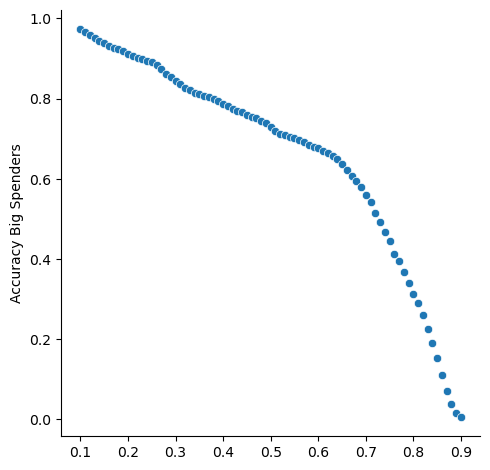

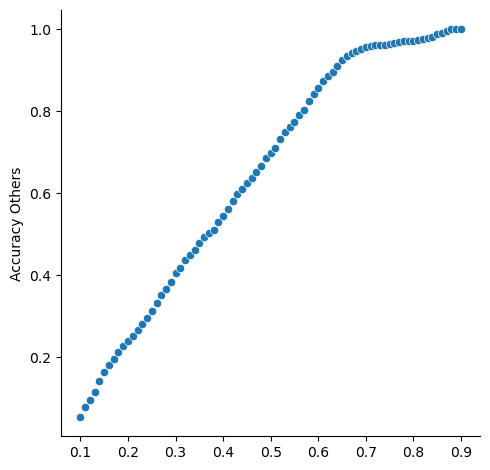

In [62]:
sns.relplot(x=values.index, y='Accuracy Big Spenders', data=values)
sns.relplot(x=values.index, y='Accuracy Others', data=values)

Text(0, 0.5, 'Accuracy')

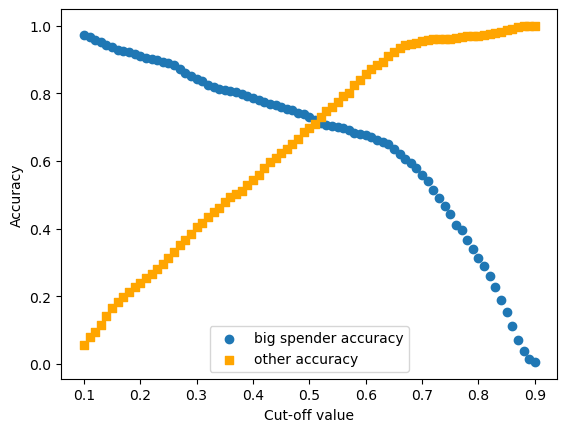

In [63]:
fig, ax = plt.subplots()
ax.scatter(values.index, y=values['Accuracy Big Spenders'], label='big spender accuracy')
ax.scatter(values.index, values['Accuracy Others'], label='other accuracy', marker='s', color='orange')
ax.legend()
ax.set_xlabel('Cut-off value')
ax.set_ylabel('Accuracy')